Consider the following Poisson equation with Dirichlet boundary condition over a bounded domain $\Omega\subset\mathbb{R}^d$
\begin{equation}
\begin{cases}
-\Delta u(x) = f(x), & \;\text{in} \;\Omega,\\
u(x) = g(x), & \; \text{on} \; \partial\Omega, 
\end{cases}
\end{equation}
where $f, g$ are given functions. 
Denote $u(x;\theta)$   the approximate NN solution with the set of parameters  $\theta$  in the NN. The collection of all $u(x;\theta)$ is used as the trial space.

## 1. Setup

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LogNorm
from math import *
import time
import copy
import itertools
from tqdm import *
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

torch.set_default_tensor_type('torch.DoubleTensor')

## 2. Hyperparameter

In [ ]:
# %%
dimension_list = [10]
# dimension_list = list(range(1,4,1))
# net_width_list = list(range(25, 150, 25))
net_width_list = [10]

## 3. Neural Architecture

In [ ]:
# %%
# activation function
def activation(x):
    return x * torch.sigmoid(x)

# %%
# build ResNet with one blocks
class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width):
        super(Net,self).__init__()
        self.layer1 = torch.nn.Linear(input_width, layer_width)
        self.layer2 = torch.nn.Linear(layer_width, layer_width)
        self.layer3 = torch.nn.Linear(layer_width, layer_width)
        self.layer4 = torch.nn.Linear(layer_width, 1)
        self.initialize_weights()
    def forward(self,x):
        y = activation(self.layer1(x))
        y = activation(self.layer3(activation(self.layer2(y)))) # residual block 1
        output = self.layer4(y)
        return output
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        # print(self)
        print('Total number of parameters: %d' % num_params)

# %%
#net = Net(input_width,layer_width)


The experiment define the neural network $\mathcal{N}: \mathbb{R}^d \rightarrow \mathbb{R}$ as follows:
\begin{equation}
\mathcal{N}(\vec{x}) := \sigma(A_4\cdot\sigma(A_3\cdot\sigma (A_2\cdot\sigma (A_1))))
\end{equation}
where ${\rm A}_{1}, {\rm A}_2, {\rm A}_{3},$ and ${\rm A}_{4}$ are fully-connected layers with the activation function $\sigma$. The number of parameters in $\mathcal{N}$ is given by $p = (d \cdot {\rm width} + {\rm width}) + 2({\rm width} \cdot {\rm width} + {\rm width}) + ({\rm width} \cdot 1 + 1) = 2 \cdot {\rm width}^2 + (4 + d) \cdot {\rm width} + 1$.

note: there are $p$ parameters need to be trained in total in ${\rm N}(x)$

## 4. Training Setup

### 4.1 Initialize the weights using Xavier normal initialization

In [ ]:
# %%
# Xavier normal initialization for weights:
#             mean = 0 std = gain * sqrt(2 / fan_in + fan_out)
# zero initialization for biases
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m,nn.Linear):
            nn.init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()

# %%
#initialize_weights(net)

### 4.2 Define the exact solution

$$[0,1]^d{\ni}{\vec x} {↦} u(x) = {∏}_{i=1}^d{\sin}(π{\vec x}_i) {∈} {\mathbb R}$$

In [ ]:
# %%
# defination of exact solution
def u_ex(x, dimension):
    temp = 1.0
    for i in range(dimension):
        temp = temp * torch.sin(pi*x[:, i])
    u_temp = 1.0 * temp
    return u_temp.reshape([x.size()[0], 1])

### 4.3 Define the $f(x)$
$$[0,1]^d{\ni }{\vec x} {↦} f({\vec x}) = dπ^2{∏}_{i=1}^d\sin(πx_i){∈}{\mathbb R}$$

In [ ]:
# %%
# defination of f(x)
def f(x, dimension):
    temp = 1.0
    for i in range(dimension):
        temp = temp * torch.sin(pi*x[:, i])
    u_temp = 1.0 * temp
    f_temp = dimension * pi**2 * u_temp
    return f_temp.reshape([x.size()[0], 1])


### 4.4 Generate sample

In [ ]:
# %%
# generate points by random
def generate_sample(data_size, dimension):
    sample_temp = torch.rand(data_size, dimension)
    return sample_temp

### 4.5 Build the model
\begin{equation}
model = u(x;\theta) = \frac{\left(\displaystyle\prod_{i=1}^d (1-x_i) x_i\right)}{(\frac{1}{5})^d}\cdot NN(x;\theta).
\end{equation}
In high dimension problem, a normalization term is add which ensures the output of the neural network is scaled properly. In dimension 50 problem, $(\frac{1}{5})^d$was selected, where $NN(x;\theta)$ is a function represented by a neural network. 

In [ ]:

def model(x):
    x_temp = x
    D_x_0 = torch.prod(x_temp, axis=1).reshape([x.size()[0], 1])
    D_x_1 = torch.prod(1.0 - x_temp, axis=1).reshape([x.size()[0], 1])
    scaling_factor = (1/5)**x.size()[1] # added scaling factor
    model_u_temp = (1/scaling_factor) * D_x_0 * D_x_1 * net(x)
    return model_u_temp.reshape([x.size()[0], 1])

###4.6 Define Loss function（energy）
 \begin{equation}
\mathcal{L}_{energy}(\hat{u}) = \frac{1}{N} \sum_{i=1}^{N} \left[ \frac{1}{2} \left\vert \nabla \hat{u}(\vec x_i; \theta) \right\vert^2 - f(x_i) \hat{u}(\vec x_i; \theta) \right], \quad {\vec x} \in [0,1]^d
\end{equation}
where $N$ is the total number of mesh points used in the training dataset and the index $i$ is used to iterate over the mesh points
note: for `loss_energy = torch.sum(0.5 * grad_u_sq  - f(x) * u_hat)  / len(x)`, it divides the length of x because the length of $Ω$ is 1

In [ ]:
#%%
# loss function to DRM by auto differential
def loss_function_energy(x, dimension):
    u_hat = model(x)
    grad_u_hat = torch.autograd.grad(outputs=u_hat, inputs=x, grad_outputs=torch.ones(u_hat.shape), create_graph=True)
    grad_u_sq = ((grad_u_hat[0] ** 2).sum(1)).reshape([len(grad_u_hat[0]), 1])
    loss_energy = torch.sum(0.5 * grad_u_sq - f(x, dimension) * u_hat) / len(x)
    return loss_energy

### 4.7 Define Fractional Error

$${\rm error} = \frac{\lVert \hat u - u \lVert _2^2}{\lVert u \lVert _2^2}$$

In [ ]:
def fractional_error(x):
  u_hat = model(x)
  u = u_ex(x, input_width)
  upper = torch.square((u_hat - u).norm(2))
  lower = torch.square(u.norm(2))
  return torch.divide(upper, lower)

## 5. Doing The Training

In [ ]:
random.seed(100)
test_sample_size = 10000
batch_size = 2000
epoch = 10000

In [ ]:
energy_loss_mat_e = np.zeros((len(net_width_list), len(dimension_list)))
energy_fractional_error = np.zeros((len(net_width_list), len(dimension_list)))
all_data = []
epoch_data = []
loss_record_e = []
error_record_e = []
loss_epoch_e = []
error_epoch_e = []

for dim_item in range(len(dimension_list)):
    input_width = dimension_list[dim_item]
    test_sample = generate_sample(test_sample_size, input_width)
    for width_item in range(len(net_width_list)):
        print("The current width:"+ str(net_width_list[width_item]))
        print("The current dimensions:"+ str(dimension_list[dim_item]))
        layer_width = net_width_list[width_item]
        net = Net(input_width, layer_width)
        initialize_weights(net)
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
        data_size = batch_size
        loss_epoch = []
        error_epoch = []
        for i in range(epoch):
            optimizer.zero_grad()
            x = generate_sample(data_size, input_width)
            x.requires_grad = True
            loss = loss_function_energy(x, input_width)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()

            test_sample_fractional_error = fractional_error(test_sample)
            loss_epoch.append(float(loss))
            error_epoch.append(float(test_sample_fractional_error))

        test_sample_fractional_error = fractional_error(test_sample)
        energy_fractional_error[width_item, dim_item] = float(test_sample_fractional_error)
        energy_loss_mat_e[width_item, dim_item] = float(loss)
        loss_record_e.append(float(loss))
        error_record_e.append(float(test_sample_fractional_error))
        loss_epoch_e.append(loss_epoch)
        error_epoch_e.append(error_epoch)

all_data.append(loss_record_e)
all_data.append(error_record_e)
all_data.append(net_width_list)
epoch_data.append(loss_epoch_e)
epoch_data.append(error_epoch_e)

with open('loss_record_all.pkl', 'wb') as f:
     pickle.dump(all_data, f)

with open('epoch_record.pkl', 'wb') as f:
     pickle.dump(epoch_data, f)

The current width:50
The current dimensions:50


In [ ]:
# plot the performance of first 100 training epoch
# loss_first_100_epochs = loss_epoch[0:100]
# error_first_100_epochs = error_epoch[0:100]

In [ ]:
# x_values = range(0, 100)

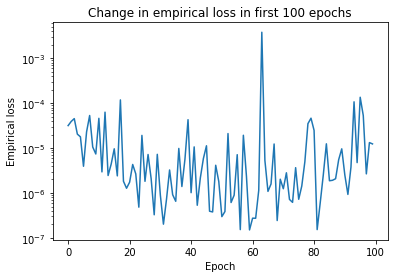

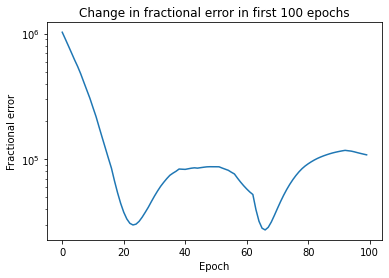

In [ ]:
# plt.plot(x_values, loss_first_100_epochs)
# plt.xlabel('Epoch')
# plt.ylabel('Empirical loss')
# plt.yscale('log')
# plt.title('Change in empirical loss in first 100 epochs')
# plt.show()
# plt.plot(x_values, error_first_100_epochs)
# plt.xlabel('Epoch')
# plt.ylabel('Fractional error')
# plt.yscale('log')
# plt.title('Change in fractional error in first 100 epochs')
# plt.show()

In [ ]:
with open('loss_record_all.pkl', 'rb') as f:
    b = pickle.load(f)

In [ ]:
print(b)

[[-0.11599906393233207, -0.07679079645679178, -0.20979990419691955, -0.23379716439632175, -0.17102362454457035, -0.24737852234646834, -0.3412508285945717, -0.23916233435131853, -0.3597977685327539, -0.3382821937784934, -0.2052751830753395, 0.2084883624091506, -0.23444488547635636, -0.2664933977071118, -0.18694429938995644, -0.44528769791300277, -0.3091018552962776, -0.268113515105025, -0.544496389494351, -0.5759017313943748, 0.1860043560961403, -0.2117968218274205, -0.3574219802388537, -0.3127460791671465, -0.4604317124271969, -0.3736503875639243, -0.6646312460729122, -0.6659794938154125, -0.5761511419191107, -0.5301993028656427], [5021.506101538391, 5021.506101538391, 5021.506101538391, 5021.506101538391, 5021.506101538391, 5021.506101538391, 5021.506101538391, 5021.506101538391, 5021.506101538391, 5021.506101538391, 2483.7299441239184, 2483.7299441239184, 2483.7299441239184, 2483.7299441239184, 2483.7299441239184, 2483.7299441239184, 2483.7299441239184, 2483.7299441239184, 2483.72994

## 6. Plotting The Output

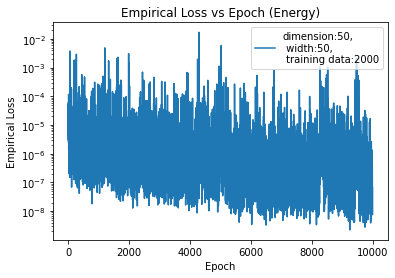

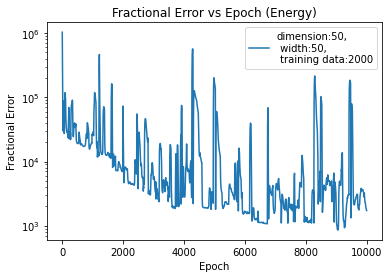

In [ ]:
# x_axis = dimension_list
# y_axis = net_width_list
# fig, axee = plt.subplots(figsize=(8, 6))
# axee = sns.heatmap(energy_loss_mat_e, xticklabels=x_axis,yticklabels=y_axis, ax=axee, cmap='coolwarm', norm=LogNorm())
# axee.invert_yaxis()
# axee.set_xlabel("PDE dimension")
# axee.set_ylabel("Net Width")
# axee.set_title("Empirical Loss (Energy)")
# cbar = axee.collections[0].colorbar
# cbar.set_label('Empirical Loss (log-scale)')
# plt.show()

# fig, axef = plt.subplots(figsize=(8, 6))
# axef = sns.heatmap(energy_fractional_error, xticklabels=dimension_list, yticklabels=net_width_list, ax=axef, cmap='coolwarm', norm=LogNorm())
# plt.gca().invert_yaxis()
# axef.set_xlabel("PDE dimension")
# axef.set_ylabel("Net Width")
# axef.set_title("Fractional Error (Energy)")
# cbar = axef.collections[0].colorbar
# cbar.set_label('Fractional Error (log-scale)')
# plt.show()


label = f'dimension:{input_width},\n width:{layer_width},\n training data:{batch_size}'
plt.plot(range(epoch), loss_epoch, label = label)
plt.title('Empirical Loss vs Epoch (Energy)')
plt.xlabel('Epoch')
plt.ylabel('Empirical Loss')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(range(epoch), error_epoch, label = label)
plt.title('Fractional Error vs Epoch (Energy)')
plt.xlabel('Epoch')
plt.ylabel('Fractional Error')
plt.yscale('log')
plt.legend()
plt.show()